# Installations

In [1]:
!pip install --quiet zipfile36
!pip install pandas

import os
import time
import random
import warnings
import threading 
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import math
import os
import json
import random
import sys
from itertools import groupby
import matplotlib.cm as cm
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession

# for verification
# import sklearn



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=4070e80f681501a12ded6bcbd49fea9aac54832b8860e592c40d508c73e3a9c7
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


# PySpark activation

In [2]:
spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .getOrCreate()

sc=spark.sparkContext

# DBSCAN on PySpark

In [3]:
def PySpark_DBSCAN(working_data,epsilon,min_num_points):

  def create_cell_neighbors(cell):
    # This function is used to connect each cell to its neighbors, turning the "dense" cells to a graph
    return [(cell[0]-1,cell[1]-1),(cell[0]-1,cell[1]),(cell[0]-1,cell[1]+1),(cell[0],cell[1]+1),(cell[0]+1,cell[1]+1),(cell[0]+1,cell[1]),(cell[0]+1,cell[1]-1),(cell[0],cell[1]-1)]

  def reduce_result_to_graph(quadrant_list):
     # This function turns the first MapReduce results from a list of cells to a graph
    edges = []
    full_cells = dict(quadrant_list).keys()
    for cell in full_cells:
      for neighbor in create_cell_neighbors(cell):
        if neighbor in full_cells:
          edges.append((cell,neighbor))
          edges.append((neighbor,cell))
    return edges


  def small_mapper(edge):
    # This function is a mapper for the "Small Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    if edge[0] <= edge[1]:
      return edge
    else:
      return (edge[1],edge[0])

  def connect_to_small(node,neighbors):
    # This function is a reducer for the "Small Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    nodes = [i[1] for i in neighbors]
    minimal = min([node]+nodes)
    new_edges = []
    for neighbor in nodes:
      new_edges.append((minimal,nighbor))


  def small_star_map(edge):
    # This function is a second mapper for the "Small Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    if edge[1] <= edge[0]:
      return edge
    elif edge[1] > edge[0]:
      return (edge[1],edge[0])
    else:
      print("error")

  def small_reductor(weird_tuple):
    # This function is a second reducer for the "Small Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    nodes = [weird_tuple[0]] + weird_tuple[1]
    minimal = min(nodes)
    nodes.remove(minimal)
    return [(i,minimal) for i in nodes]


  def large_star_reduce(weird_tuple):
    # This function is the reducer for the "Large Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    nodes = [weird_tuple[0]] + weird_tuple[1]
    minimal = min(nodes)
    nodes = list(filter(lambda nodes: nodes >= weird_tuple[0], nodes))
    return [(i,minimal) for i in nodes]

  def round(graph):
    # This function does one "round" of the "Alternating" algorithm from the article, doing small-star-MapRedue and the large-star-MapReduce
    first_large_star = sc.parallelize(graph).groupByKey().mapValues(list).map(lambda row: large_star_reduce(row)).collect()
    first_small_star = sc.parallelize([item for sublist in first_large_star for item in sublist]).map(lambda row: small_star_map(row)).groupByKey().mapValues(list).map(lambda row: small_reductor(row)).collect()
    flattened = [item for sublist in first_small_star for item in sublist]
    flattened += [reverser(i) for i in flattened]
    return list(set(filter(lambda flattened: flattened[0] != flattened[1], flattened)))

  def reverser(edge):
    # Helper function for the large star mapping
    return (edge[1],edge[0])

  def whole_round(graph):
    # This function does rounds of the "Alternating" algorithm from the article until convergence
    finished = False
    last_graph = graph
    while not finished:
      new_graph = round(last_graph)
      if set(new_graph) == set(last_graph):
        finished = True
      else:
        last_graph = new_graph
    return sc.parallelize(new_graph).map(lambda row: small_mapper(row)).groupBy(lambda x: x[0]).map(lambda x: (x[0], list(x[1]))).collect()

  def normalize(v):
    # This function normalizes the data to go from 0 to 1, in both axes
      gap = v.max()-v.min()
      v1 = v/gap
      min = v1.min()
      v2 = v1 - np.array([min for i in v])
      return v2


  def mapfunc(point):
    # This is the mapper for the first MapReduce, which turns points into cells
      x_cell = math.floor((point[0]-x_min)/epsilon)
      y_cell = math.floor((point[1]-y_min)/epsilon)
      return [(x_cell,y_cell),1]

  def reducefunc(key, values):
      counts = [x[1] for x in values]
      if sum(counts) >= min_num_points:
        return [key,sum(counts)]


  x=normalize(working_data[working_data.columns.values.tolist()[0]])
  y=normalize(working_data[working_data.columns.values.tolist()[1]])

  range_x = x.max()-x.min()
  range_y = y.max()-y.min()
  x_min = x.min()
  y_min = y.min()

  working_data=pd.DataFrame({'x': x, 'y': y}, columns=['x', 'y']).to_numpy()

  cells = sc.parallelize(working_data).map(lambda row: mapfunc(row)).reduceByKey(lambda x, y: x + y).collect()
  cells = list(set(filter(lambda cells: cells[1]>min_num_points, cells)))

  return whole_round(reduce_result_to_graph(cells))

# The Data

In [4]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]



<Figure size 1512x936 with 0 Axes>

In [5]:
  # a = [(random.random()*3 + 10,random.random()*2 + 7) for i in range(80)]
  # b = [(random.random()*2 ,random.random()*8 + 5) for i in range(80)]
  # c = [(random.random()*9 + 3,random.random()*0.1) for i in range(80)]

  # df = pd.DataFrame(a+b+c)


  # working_data = df[[df.columns.values.tolist()[0],df.columns.values.tolist()[1] ]]


In [6]:
  df = pd.DataFrame(datasets[0][0][0])


  working_data = df[[df.columns.values.tolist()[0],df.columns.values.tolist()[1] ]]

In [7]:
  # a = [(random.gauss(mu=2.0, sigma=1.0)*3 + 10,random.gauss(mu=2.0, sigma=1.0)*2 + 7) for i in range(800)]
  # b = [(random.gauss(mu=2.0, sigma=1.0)*2 ,random.gauss(mu=2.0, sigma=1.0)*8 + 5) for i in range(800)]
  # c = [(random.gauss(mu=2.0, sigma=1.0)*9 + 3,random.gauss(mu=2.0, sigma=1.0)*0.1) for i in range(800)]

  # df = pd.DataFrame(a+b+c)


  # working_data = df[[df.columns.values.tolist()[0],df.columns.values.tolist()[1] ]]


In [8]:
# plt.plot(working_data)

# The Algorithm runtime

In [9]:
print("There are "+str(len(PySpark_DBSCAN(working_data,0.05,3)))+" clusters in the data")

There are 8 clusters in the data


# Graphics

In [10]:
def color_quadrants(quad_list):
  counter = 0
  colors=cm.rainbow(np.linspace(0, 1, len(quad_list)))
  color_dict = {}
  for i in quad_list:
    color_dict[i[0]] = colors[counter]
    for j in i[1]:
      color_dict[j[1][0],j[1][1]]=colors[counter]
    counter += 1
  return color_dict

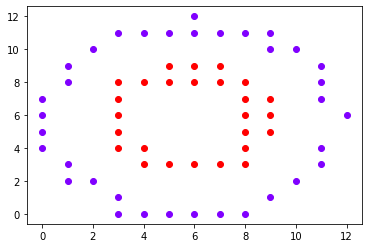

In [11]:
dot_colors = color_quadrants(PySpark_DBSCAN(working_data,0.08,3))
for i in dot_colors:
  plt.scatter(i[0],i[1],color=dot_colors[i])


In [12]:
dot_colors

{(0, 4): array([0.5, 0. , 1. , 1. ]),
 (5, 11): array([0.5, 0. , 1. , 1. ]),
 (0, 6): array([0.5, 0. , 1. , 1. ]),
 (9, 11): array([0.5, 0. , 1. , 1. ]),
 (11, 9): array([0.5, 0. , 1. , 1. ]),
 (3, 11): array([0.5, 0. , 1. , 1. ]),
 (1, 9): array([0.5, 0. , 1. , 1. ]),
 (10, 10): array([0.5, 0. , 1. , 1. ]),
 (10, 2): array([0.5, 0. , 1. , 1. ]),
 (7, 0): array([0.5, 0. , 1. , 1. ]),
 (5, 0): array([0.5, 0. , 1. , 1. ]),
 (1, 3): array([0.5, 0. , 1. , 1. ]),
 (0, 7): array([0.5, 0. , 1. , 1. ]),
 (9, 10): array([0.5, 0. , 1. , 1. ]),
 (8, 0): array([0.5, 0. , 1. , 1. ]),
 (6, 12): array([0.5, 0. , 1. , 1. ]),
 (4, 0): array([0.5, 0. , 1. , 1. ]),
 (2, 2): array([0.5, 0. , 1. , 1. ]),
 (11, 3): array([0.5, 0. , 1. , 1. ]),
 (4, 11): array([0.5, 0. , 1. , 1. ]),
 (11, 7): array([0.5, 0. , 1. , 1. ]),
 (7, 11): array([0.5, 0. , 1. , 1. ]),
 (6, 0): array([0.5, 0. , 1. , 1. ]),
 (0, 5): array([0.5, 0. , 1. , 1. ]),
 (12, 6): array([0.5, 0. , 1. , 1. ]),
 (1, 8): array([0.5, 0. , 1. , 1. ])

# Linear comparison

In [13]:
class Graph_structure:

   def __init__(self, V):
      self.V = V
      self.adj = [[] for i in range(V)]

   def DFS_Utility(self, temp, v, visited):

      visited[v] = True

      temp.append(v)

      for i in self.adj[v]:
         if visited[i] == False:

            temp = self.DFS_Utility(temp, i, visited)
      return temp

   def add_edge(self, v, w):
      self.adj[v].append(w)
      self.adj[w].append(v)

   def connected_components(self):
      visited = []
      connected_comp = []
      for i in range(self.V):
         visited.append(False)
      for v in range(self.V):
         if visited[v] == False:
            temp = []
            connected_comp.append(self.DFS_Utility(temp, v, visited))
      return connected_comp
def cells_alias(quadrant_list):
  alias = {}
  reverse_alias = {}
  counter = 0
  for cell in quadrant_list:
    alias[cell] = counter
    reverse_alias[counter] = cell
    counter += 1
  return alias,reverse_alias

def Linear_DBSCAN(working_data,epsilon,min_num_points):

  def create_cell_neighbors(cell):
    # This function is used to connect each cell to its neighbors, turning the "dense" cells to a graph
    return [(cell[0]-1,cell[1]-1),(cell[0]-1,cell[1]),(cell[0]-1,cell[1]+1),(cell[0],cell[1]+1),(cell[0]+1,cell[1]+1),(cell[0]+1,cell[1]),(cell[0]+1,cell[1]-1),(cell[0],cell[1]-1)]

  def reduce_result_to_graph(quadrant_list):
     # This function turns the first MapReduce results from a list of cells to a graph
    edges = []
    full_cells = dict(quadrant_list).keys()
    for cell in full_cells:
      for neighbor in create_cell_neighbors(cell):
        if neighbor in full_cells:
          edges.append((cell,neighbor))
          edges.append((neighbor,cell))
    return edges


  def small_mapper(edge):
    # This function is a mapper for the "Small Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    if edge[0] <= edge[1]:
      return edge
    else:
      return (edge[1],edge[0])

  def connect_to_small(node,neighbors):
    # This function is a reducer for the "Small Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    nodes = [i[1] for i in neighbors]
    minimal = min([node]+nodes)
    new_edges = []
    for neighbor in nodes:
      new_edges.append((minimal,nighbor))


  def small_star_map(edge):
    # This function is a second mapper for the "Small Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    if edge[1] <= edge[0]:
      return edge
    elif edge[1] > edge[0]:
      return (edge[1],edge[0])
    else:
      print("error")

  def small_reductor(weird_tuple):
    # This function is a second reducer for the "Small Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    nodes = [weird_tuple[0]] + weird_tuple[1]
    minimal = min(nodes)
    nodes.remove(minimal)
    return [(i,minimal) for i in nodes]


  def large_star_reduce(weird_tuple):
    # This function is the reducer for the "Large Star Operation" outlined in the "Connected Components in MapReduce and Beyond" article
    nodes = [weird_tuple[0]] + weird_tuple[1]
    minimal = min(nodes)
    nodes = list(filter(lambda nodes: nodes >= weird_tuple[0], nodes))
    return [(i,minimal) for i in nodes]

  def round(graph):
    # This function does one "round" of the "Alternating" algorithm from the article, doing small-star-MapRedue and the large-star-MapReduce
    first_large_star = sc.parallelize(graph).groupByKey().mapValues(list).map(lambda row: large_star_reduce(row)).collect()
    first_small_star = sc.parallelize([item for sublist in first_large_star for item in sublist]).map(lambda row: small_star_map(row)).groupByKey().mapValues(list).map(lambda row: small_reductor(row)).collect()
    flattened = [item for sublist in first_small_star for item in sublist]
    flattened += [reverser(i) for i in flattened]
    return list(set(filter(lambda flattened: flattened[0] != flattened[1], flattened)))

  def reverser(edge):
    # Helper function for the large star mapping
    return (edge[1],edge[0])

  def whole_round(graph):
    # This function does rounds of the "Alternating" algorithm from the article until convergence
    finished = False
    last_graph = graph
    while not finished:
      new_graph = round(last_graph)
      if set(new_graph) == set(last_graph):
        finished = True
      else:
        last_graph = new_graph
    return sc.parallelize(new_graph).map(lambda row: small_mapper(row)).groupBy(lambda x: x[0]).map(lambda x: (x[0], list(x[1]))).collect()

  def normalize(v):
    # This function normalizes the data to go from 0 to 1, in both axes
      gap = v.max()-v.min()
      v1 = v/gap
      min = v1.min()
      v2 = v1 - np.array([min for i in v])
      return v2


  def mapfunc(point):
    # This is the mapper for the first MapReduce, which turns points into cells
      x_cell = math.floor((point[0]-x_min)/epsilon)
      y_cell = math.floor((point[1]-y_min)/epsilon)
      return [(x_cell,y_cell),1]

  def reducefunc(key, values):
      counts = [x[1] for x in values]
      if sum(counts) >= min_num_points:
        return [key,sum(counts)]


  x=normalize(working_data[working_data.columns.values.tolist()[0]])
  y=normalize(working_data[working_data.columns.values.tolist()[1]])

  range_x = x.max()-x.min()
  range_y = y.max()-y.min()
  x_min = x.min()
  y_min = y.min()

  working_data=pd.DataFrame({'x': x, 'y': y}, columns=['x', 'y']).to_numpy()

  cells = {}
  for point in working_data:
    cell = mapfunc(point)[0]
    if cell in cells:
      cells[cell] += 1
    else:
      cells[cell] = 1
  
  cells = {k: v for k, v in cells.items() if v > 1}
  edges = []
  for cell in cells.keys():
      for neighbor in create_cell_neighbors(cell):
        if neighbor in cells:
          edges.append((cell,neighbor))
          edges.append((neighbor,cell))
  
  graph = Graph_structure(len(cells))
  cell_alises,cell_reverse_alises = cells_alias(cells)
  for edge in edges:
    graph.add_edge(cell_alises[edge[0]],cell_alises[edge[1]])
  conn_comp = graph.connected_components()
  new_conn_comp = []
  for comp in conn_comp:
    new_conn_comp.append((cell_reverse_alises[comp[0]],comp))
  newer_conn_comp = []
  for comp in new_conn_comp:
    internal_conn_comp = []
    for node in comp[1]:
      internal_conn_comp.append((comp[0],cell_reverse_alises[node]))
    newer_conn_comp.append((comp[0],internal_conn_comp))
  return newer_conn_comp

In [14]:
Linear_DBSCAN(working_data,0.08,3)

[((2, 10),
  [((2, 10), (2, 10)),
   ((2, 10), (1, 9)),
   ((2, 10), (1, 8)),
   ((2, 10), (0, 7)),
   ((2, 10), (0, 8)),
   ((2, 10), (0, 6)),
   ((2, 10), (0, 5)),
   ((2, 10), (0, 4)),
   ((2, 10), (1, 3)),
   ((2, 10), (2, 2)),
   ((2, 10), (1, 2)),
   ((2, 10), (2, 1)),
   ((2, 10), (3, 0)),
   ((2, 10), (3, 1)),
   ((2, 10), (4, 0)),
   ((2, 10), (5, 0)),
   ((2, 10), (6, 0)),
   ((2, 10), (7, 0)),
   ((2, 10), (8, 0)),
   ((2, 10), (9, 1)),
   ((2, 10), (10, 2)),
   ((2, 10), (11, 3)),
   ((2, 10), (11, 4)),
   ((2, 10), (11, 5)),
   ((2, 10), (11, 6)),
   ((2, 10), (12, 6)),
   ((2, 10), (11, 7)),
   ((2, 10), (11, 8)),
   ((2, 10), (11, 9)),
   ((2, 10), (10, 9)),
   ((2, 10), (10, 10)),
   ((2, 10), (9, 11)),
   ((2, 10), (8, 11)),
   ((2, 10), (7, 11)),
   ((2, 10), (6, 11)),
   ((2, 10), (5, 12)),
   ((2, 10), (4, 11)),
   ((2, 10), (3, 11)),
   ((2, 10), (5, 11)),
   ((2, 10), (6, 12)),
   ((2, 10), (9, 10)),
   ((2, 10), (12, 5)),
   ((2, 10), (10, 3)),
   ((2, 10), (10, 

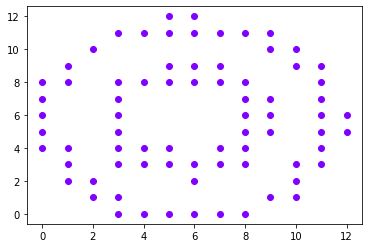

In [15]:
dot_colors = color_quadrants(Linear_DBSCAN(working_data,0.08,3))
for i in dot_colors:
  plt.scatter(i[0],i[1],color=dot_colors[i])


In [16]:
def draw_clusters(df,epsilon,min_num_points):
  working_data = df[[df.columns.values.tolist()[0],df.columns.values.tolist()[1] ]]
  def normalize(v):
    # This function normalizes the data to go from 0 to 1, in both axes
      gap = v.max()-v.min()
      v1 = v/gap
      min = v1.min()
      v2 = v1 - np.array([min for i in v])
      return v2
  x=normalize(working_data[working_data.columns.values.tolist()[0]])
  y=normalize(working_data[working_data.columns.values.tolist()[1]])

  range_x = x.max()-x.min()
  range_y = y.max()-y.min()
  x_min = x.min()
  y_min = y.min()
  working_data=pd.DataFrame({'x': x, 'y': y}, columns=['x', 'y'])
  def mapfunc(point):
      '''This is the mapper for the first MapReduce, which turns points into cells'''
      x_cell = math.floor((point[0]-x_min)/epsilon)
      y_cell = math.floor((point[1]-y_min)/epsilon)
      return [(x_cell,y_cell),1]
  dot_colors = color_quadrants(PySpark_DBSCAN(working_data,epsilon,min_num_points))
  for i in working_data.to_numpy():
    cell = mapfunc(i)[0]
    if cell in dot_colors:
      plt.scatter(i[0],i[1],color=dot_colors[cell])
    else:
      plt.scatter(i[0],i[1],color="b")

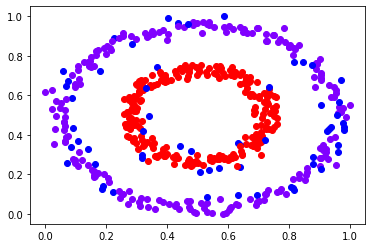

In [17]:
draw_clusters(df,0.08,3)

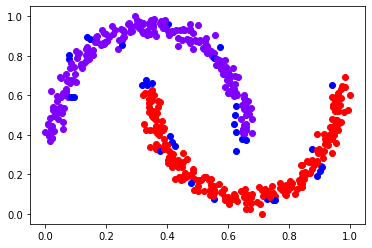

In [18]:
draw_clusters(pd.DataFrame(datasets[1][0][0]),0.08,3)

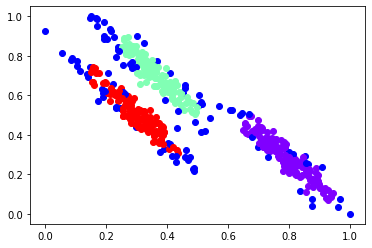

In [19]:
draw_clusters(pd.DataFrame(datasets[3][0][0]),0.05,3)

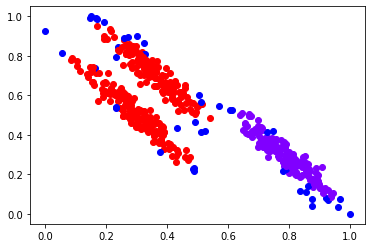

In [20]:
draw_clusters(pd.DataFrame(datasets[3][0][0]),0.08,3)

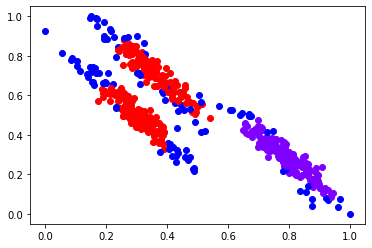

In [21]:
draw_clusters(pd.DataFrame(datasets[3][0][0]),0.08,7)

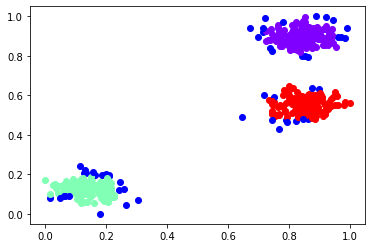

In [22]:
draw_clusters(pd.DataFrame(datasets[4][0][0]),0.048,3)

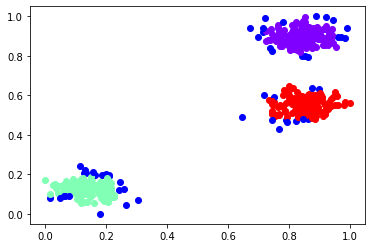

In [23]:
draw_clusters(pd.DataFrame(datasets[4][0][0]),0.048,3)

In [24]:
data1 = np.concatenate((datasets[4][0][0], datasets[1][0][0]*5))
data2 = np.concatenate((data1, datasets[0][0][0]*8))

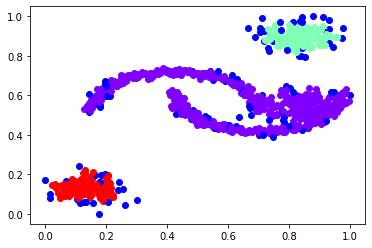

In [25]:
draw_clusters(pd.DataFrame(np.concatenate((datasets[4][0][0], datasets[1][0][0]*5))),0.04,3)

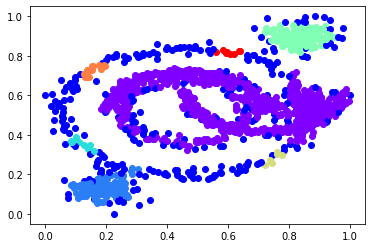

In [26]:
draw_clusters(pd.DataFrame(data2),0.04,3)

In [27]:
datasets[1][0][0]*3

array([[ 2.00908243e+00, -1.30297674e+00],
       [ 4.22250832e+00, -1.39359143e+00],
       [ 2.54560085e+00,  1.24833672e+00],
       [ 1.35225439e+00,  2.40811149e+00],
       [ 5.91000185e+00,  5.03364215e-01],
       [-1.65269600e+00,  2.68535766e+00],
       [ 2.38729032e+00,  1.73296525e+00],
       [-2.30351934e-02,  9.89439512e-01],
       [-1.17870232e+00,  3.00706503e+00],
       [ 4.69781059e+00, -1.11358799e+00],
       [ 2.92705168e+00,  2.84290374e-01],
       [ 8.09043322e-01, -1.28445426e-01],
       [-2.50542625e+00,  2.13851171e+00],
       [-1.87113264e+00,  2.15288850e+00],
       [ 4.19132531e-01,  2.97713229e+00],
       [ 2.60550784e+00, -1.54795518e+00],
       [ 4.25456890e+00, -1.28003526e+00],
       [-3.13255632e+00,  1.11230727e-01],
       [ 2.36230448e+00,  2.13061077e+00],
       [ 3.00241506e+00,  2.75531237e-02],
       [ 1.17576339e+00,  2.66729187e+00],
       [ 3.01418353e+00, -1.78851433e+00],
       [ 8.97882415e-01,  2.69031435e+00],
       [-2.

In [28]:
dot_colors

{(2, 10): array([0.5, 0. , 1. , 1. ]),
 (1, 9): array([0.5, 0. , 1. , 1. ]),
 (1, 8): array([0.5, 0. , 1. , 1. ]),
 (0, 7): array([0.5, 0. , 1. , 1. ]),
 (0, 8): array([0.5, 0. , 1. , 1. ]),
 (0, 6): array([0.5, 0. , 1. , 1. ]),
 (0, 5): array([0.5, 0. , 1. , 1. ]),
 (0, 4): array([0.5, 0. , 1. , 1. ]),
 (1, 3): array([0.5, 0. , 1. , 1. ]),
 (2, 2): array([0.5, 0. , 1. , 1. ]),
 (1, 2): array([0.5, 0. , 1. , 1. ]),
 (2, 1): array([0.5, 0. , 1. , 1. ]),
 (3, 0): array([0.5, 0. , 1. , 1. ]),
 (3, 1): array([0.5, 0. , 1. , 1. ]),
 (4, 0): array([0.5, 0. , 1. , 1. ]),
 (5, 0): array([0.5, 0. , 1. , 1. ]),
 (6, 0): array([0.5, 0. , 1. , 1. ]),
 (7, 0): array([0.5, 0. , 1. , 1. ]),
 (8, 0): array([0.5, 0. , 1. , 1. ]),
 (9, 1): array([0.5, 0. , 1. , 1. ]),
 (10, 2): array([0.5, 0. , 1. , 1. ]),
 (11, 3): array([0.5, 0. , 1. , 1. ]),
 (11, 4): array([0.5, 0. , 1. , 1. ]),
 (11, 5): array([0.5, 0. , 1. , 1. ]),
 (11, 6): array([0.5, 0. , 1. , 1. ]),
 (12, 6): array([0.5, 0. , 1. , 1. ]),
 (11,

# More Datasets

In [29]:
datasets[0]

((array([[-0.66723969,  0.76788488],
         [ 0.40066152,  0.05961979],
         [ 0.36386096,  0.37317766],
         [ 0.07814635, -0.48627362],
         [ 0.29839013, -0.55392759],
         [ 1.0275721 ,  0.38762922],
         [-0.07654603,  0.47851914],
         [ 0.50570092, -0.14228116],
         [-0.75811998, -0.65102674],
         [-0.76796954, -0.59604733],
         [ 0.93992438, -0.14745191],
         [ 0.51431718,  0.03044219],
         [-0.51715091, -0.12350501],
         [ 0.31292872,  0.48039026],
         [-0.43431081, -0.93929253],
         [-0.08625738,  0.4046198 ],
         [ 0.34002917, -0.30330994],
         [-0.43326709,  0.27002452],
         [-0.7659136 , -0.64750907],
         [ 0.53257864,  0.88447352],
         [ 0.41987109, -0.93883596],
         [-0.45394428,  0.08909939],
         [ 0.90187024, -0.31602576],
         [-0.87541731,  0.40639691],
         [ 0.41909421,  0.95871424],
         [-0.05005827, -0.53649441],
         [ 0.84467943,  0.50834078],
 

In [30]:
print(dot_colors)

{(2, 10): array([0.5, 0. , 1. , 1. ]), (1, 9): array([0.5, 0. , 1. , 1. ]), (1, 8): array([0.5, 0. , 1. , 1. ]), (0, 7): array([0.5, 0. , 1. , 1. ]), (0, 8): array([0.5, 0. , 1. , 1. ]), (0, 6): array([0.5, 0. , 1. , 1. ]), (0, 5): array([0.5, 0. , 1. , 1. ]), (0, 4): array([0.5, 0. , 1. , 1. ]), (1, 3): array([0.5, 0. , 1. , 1. ]), (2, 2): array([0.5, 0. , 1. , 1. ]), (1, 2): array([0.5, 0. , 1. , 1. ]), (2, 1): array([0.5, 0. , 1. , 1. ]), (3, 0): array([0.5, 0. , 1. , 1. ]), (3, 1): array([0.5, 0. , 1. , 1. ]), (4, 0): array([0.5, 0. , 1. , 1. ]), (5, 0): array([0.5, 0. , 1. , 1. ]), (6, 0): array([0.5, 0. , 1. , 1. ]), (7, 0): array([0.5, 0. , 1. , 1. ]), (8, 0): array([0.5, 0. , 1. , 1. ]), (9, 1): array([0.5, 0. , 1. , 1. ]), (10, 2): array([0.5, 0. , 1. , 1. ]), (11, 3): array([0.5, 0. , 1. , 1. ]), (11, 4): array([0.5, 0. , 1. , 1. ]), (11, 5): array([0.5, 0. , 1. , 1. ]), (11, 6): array([0.5, 0. , 1. , 1. ]), (12, 6): array([0.5, 0. , 1. , 1. ]), (11, 7): array([0.5, 0. , 1. ,

In [31]:
print()

In [32]:
%time Linear_DBSCAN(working_data,0.08,3)

CPU times: user 5.06 ms, sys: 867 µs, total: 5.93 ms
Wall time: 6.69 ms


[((2, 10),
  [((2, 10), (2, 10)),
   ((2, 10), (1, 9)),
   ((2, 10), (1, 8)),
   ((2, 10), (0, 7)),
   ((2, 10), (0, 8)),
   ((2, 10), (0, 6)),
   ((2, 10), (0, 5)),
   ((2, 10), (0, 4)),
   ((2, 10), (1, 3)),
   ((2, 10), (2, 2)),
   ((2, 10), (1, 2)),
   ((2, 10), (2, 1)),
   ((2, 10), (3, 0)),
   ((2, 10), (3, 1)),
   ((2, 10), (4, 0)),
   ((2, 10), (5, 0)),
   ((2, 10), (6, 0)),
   ((2, 10), (7, 0)),
   ((2, 10), (8, 0)),
   ((2, 10), (9, 1)),
   ((2, 10), (10, 2)),
   ((2, 10), (11, 3)),
   ((2, 10), (11, 4)),
   ((2, 10), (11, 5)),
   ((2, 10), (11, 6)),
   ((2, 10), (12, 6)),
   ((2, 10), (11, 7)),
   ((2, 10), (11, 8)),
   ((2, 10), (11, 9)),
   ((2, 10), (10, 9)),
   ((2, 10), (10, 10)),
   ((2, 10), (9, 11)),
   ((2, 10), (8, 11)),
   ((2, 10), (7, 11)),
   ((2, 10), (6, 11)),
   ((2, 10), (5, 12)),
   ((2, 10), (4, 11)),
   ((2, 10), (3, 11)),
   ((2, 10), (5, 11)),
   ((2, 10), (6, 12)),
   ((2, 10), (9, 10)),
   ((2, 10), (12, 5)),
   ((2, 10), (10, 3)),
   ((2, 10), (10, 

In [33]:
%time PySpark_DBSCAN(working_data,0.08,3)

CPU times: user 214 ms, sys: 35.6 ms, total: 250 ms
Wall time: 2.63 s


[((0, 4),
  [((0, 4), (5, 11)),
   ((0, 4), (0, 6)),
   ((0, 4), (9, 11)),
   ((0, 4), (11, 9)),
   ((0, 4), (3, 11)),
   ((0, 4), (1, 9)),
   ((0, 4), (10, 10)),
   ((0, 4), (10, 2)),
   ((0, 4), (7, 0)),
   ((0, 4), (5, 0)),
   ((0, 4), (1, 3)),
   ((0, 4), (0, 7)),
   ((0, 4), (0, 7)),
   ((0, 4), (9, 10)),
   ((0, 4), (8, 0)),
   ((0, 4), (6, 12)),
   ((0, 4), (4, 0)),
   ((0, 4), (3, 11)),
   ((0, 4), (7, 0)),
   ((0, 4), (8, 0)),
   ((0, 4), (2, 2)),
   ((0, 4), (9, 10)),
   ((0, 4), (11, 3)),
   ((0, 4), (4, 11)),
   ((0, 4), (11, 7)),
   ((0, 4), (7, 11)),
   ((0, 4), (6, 0)),
   ((0, 4), (0, 5)),
   ((0, 4), (12, 6)),
   ((0, 4), (1, 8)),
   ((0, 4), (11, 4)),
   ((0, 4), (6, 12)),
   ((0, 4), (10, 10)),
   ((0, 4), (11, 7)),
   ((0, 4), (5, 11)),
   ((0, 4), (9, 1)),
   ((0, 4), (0, 5)),
   ((0, 4), (5, 0)),
   ((0, 4), (10, 2)),
   ((0, 4), (11, 3)),
   ((0, 4), (1, 2)),
   ((0, 4), (3, 1)),
   ((0, 4), (6, 0)),
   ((0, 4), (9, 11)),
   ((0, 4), (8, 11)),
   ((0, 4), (1, 9))

In [34]:
epsilons = [0.15,0.14,0.13,0.12,0.11,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
for i in epsilons:
  %time PySpark_DBSCAN(working_data,i,1)

CPU times: user 176 ms, sys: 28.3 ms, total: 204 ms
Wall time: 2.69 s
CPU times: user 170 ms, sys: 26.1 ms, total: 196 ms
Wall time: 2.13 s
CPU times: user 186 ms, sys: 31.2 ms, total: 217 ms
Wall time: 2.24 s
CPU times: user 181 ms, sys: 24.6 ms, total: 206 ms
Wall time: 2.11 s
CPU times: user 156 ms, sys: 31.9 ms, total: 188 ms
Wall time: 2.06 s
CPU times: user 176 ms, sys: 20.6 ms, total: 196 ms
Wall time: 2.08 s
CPU times: user 192 ms, sys: 37.2 ms, total: 229 ms
Wall time: 2.76 s
CPU times: user 194 ms, sys: 29.1 ms, total: 223 ms
Wall time: 2.36 s
CPU times: user 203 ms, sys: 26.2 ms, total: 229 ms
Wall time: 2.45 s
CPU times: user 189 ms, sys: 38.8 ms, total: 228 ms
Wall time: 2.38 s
CPU times: user 202 ms, sys: 29.9 ms, total: 232 ms
Wall time: 2.38 s
CPU times: user 186 ms, sys: 33.8 ms, total: 219 ms
Wall time: 2.45 s
CPU times: user 226 ms, sys: 32.9 ms, total: 259 ms
Wall time: 2.82 s
CPU times: user 129 ms, sys: 21.2 ms, total: 150 ms
Wall time: 1.57 s
CPU times: user 52.5

In [35]:
for i in epsilons:
  print(math.ceil(1.0/i)**2)

49
64
64
81
100
100
144
169
225
289
400
625
1156
2500
10000
